## Predicting Bike Rentals
Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Descriptions of the columns in Dataset:

- **instant** - A unique sequential ID number for each row
- **dteday** - The date of the rentals
- **season** - The season in which the rentals occurred
- **yr** - The year the rentals occurred
- **mnth** - The month the rentals occurred
- **hr** - The hour the rentals occurred
- **holiday** - Whether or not the day was a holiday
- **weekday** - The day of the week (as a number, 0 to 7)
- **workingday** - Whether or not the day was a working day
- **weathersit** - The weather (as a categorical variable)
- **temp** - The temperature, on a 0-1 scale
- **atemp** - The adjusted temperature
- **hum** - The humidity, on a 0-1 scale
- **windspeed** - The wind speed, on a 0-1 scale
- **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- **registered** - The number of registered riders (people who had already signed up)
- **cnt** - The total number of bike rentals (casual + registered)

In this project, we are going to predict the total number of bikes people rented in a given hour. We'll predict the **cnt** column using all of the other columns, except for casual and registered. We will create few different machine learning models and evaluate their performance.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [3]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

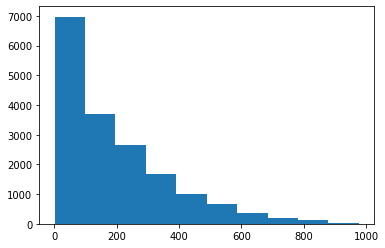

In [5]:
plt.hist(bike_rentals['cnt'])

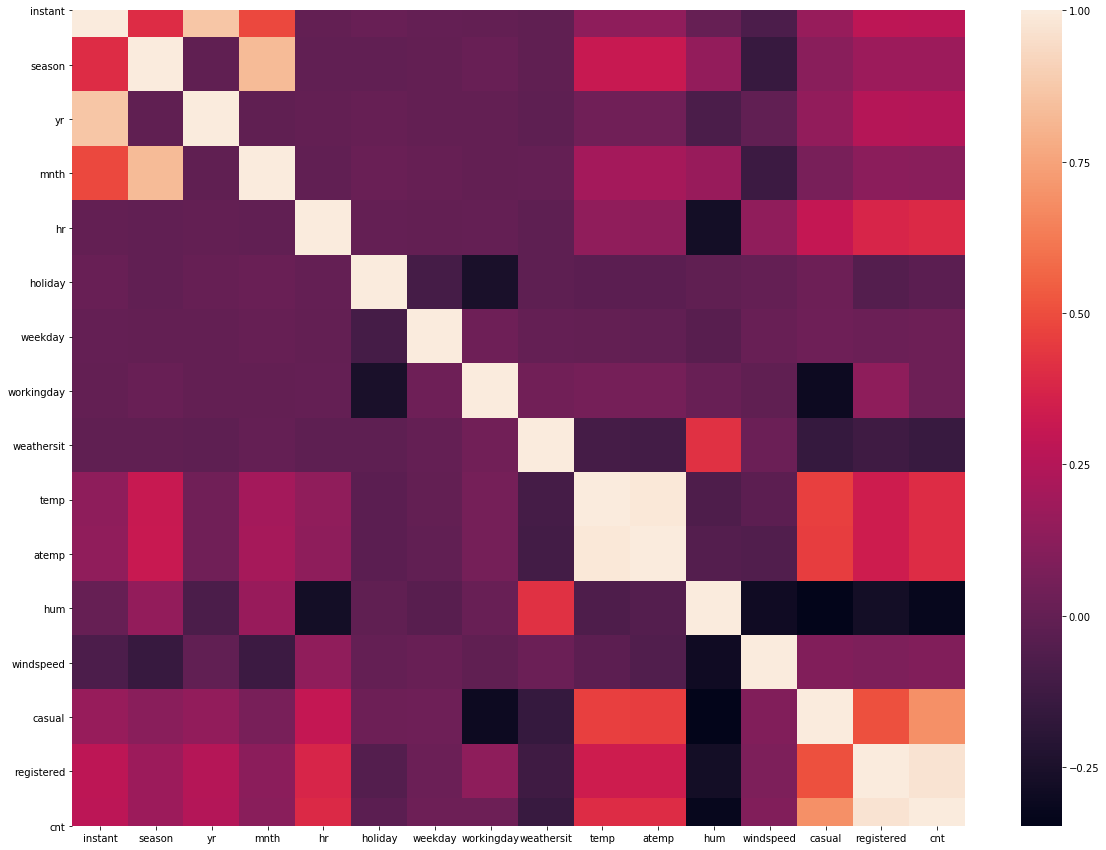

In [6]:
corr = bike_rentals.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr)

In [7]:
corr['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.
<br/>
<br/>
    For example, the **hr** column in **bike_rentals** contains the hours during which bikes are rented, from **1** to **24**. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for **morning**, **afternoon**, **evening**, and **night**. This will bundle similar times together, enabling the model to make better decisions.

In [8]:
for each in bike_rentals['hr']:
    # For Morning
    if each >= 0 and each < 6:
        bike_rentals['time_label'] = 1
    # For Afternoon
    elif each >= 6 and each < 12:
        bike_rentals['time_label'] = 2
    # For Evening
    elif each >= 12 and each < 18:
        bike_rentals['time_label'] = 3
    # For Night
    else:
        bike_rentals['time_label'] = 4

Before you can begin applying machine learning algorithms, you'll need to split the data into training and testing sets. This will enable you to train an algorithm using the training set, and evaluate its accuracy on the testing set. If you train an algorithm on the training data, then evaluate its performance on the same data, you can get an unrealistically low error value, due to overfitting.

In [9]:
train = bike_rentals.sample(frac=0.8, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]
print(train.shape[0])
print(test.shape[0])

13903
3476


Let's try Linear regression which will probably work fairly well on this data, given that many of the columns are highly correlated with **cnt**.
<br/>
<br/>
As we learned in earlier missions, linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

We have to ignore the **casual** and **registered** columns because **cnt** is derived from them.

In [10]:
predictors = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 
              'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
              'time_label']
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(train[predictors], train['cnt'])
predictions = model.predict(test[predictors])

mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)
print('Root Mean Squared Error:',rmse)

Root Mean Squared Error: 139.93117790705188


Let's apply Decision tree Algorithm and compare its error with the error from linear regression.
<br/>
<br/>
Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [11]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=150, min_samples_leaf=5)
model.fit(train[predictors], train['cnt'])
predictions = model.predict(test[predictors])
print('Error:', np.sqrt(mean_squared_error(test['cnt'], predictions)))

Error: 52.285456249637456


So, We can see that on using DecisionTreeRegressor Algorithm we can decrease our errors from 140 to 52 approx.
<br/>
<br/>
Let's apply random forest algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [12]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=150, min_samples_leaf=2)
model.fit(train[predictors], train['cnt'])
predictions = model.predict(test[predictors])
print('Error:', np.sqrt(mean_squared_error(test['cnt'], predictions)))

Error: 43.02220509132101


So, after checking various values for `n_estimators`(number of trees) finally we can decrease the error from 140 to 43 approx.